In [358]:
import pandas as pd
import numpy as np
from darts.timeseries import TimeSeries
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from xgboost import plot_importance, plot_tree

from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [359]:
import warnings
warnings.filterwarnings('ignore')

In [360]:
# dark_palette = ['#3E4095','#9F3E4B','#4D9458','#5D4774','#ADAA27']
# light_palette = ['#A6ABE4','#E3A3A7','#B2D9B8','#C6B9CF','#D9D89F']

In [361]:
# def prepararDatosXY(data, y_nombre):

#     # toma el dataframe, el nombre de la variable x (la fecha) y la y (la variable a ajustar)
#     # retorna tres timeseries data, train y test

#     train = data[:int(0.85*(len(data)))].iloc[1:]
#     test = data[int(0.85*(len(data))):]

#     train_x = train[train.columns.difference([y_nombre])]
#     train_y = pd.DataFrame(train[y_nombre])

#     test_x = test[test.columns.difference([y_nombre])]
#     test_y = pd.DataFrame(test[y_nombre])
    

#     return train_x, train_y, test_x, test_y

In [362]:
df = pd.read_excel('datos.xlsx')
#df = df[['mes','v_total']]
df = df.drop(df.columns[range(2,13)], axis = 1)
df = df.drop(columns = ['int_ret_sup'])
#df.replace(0, np.nan, inplace=True)

In [363]:
df

,mes,v_total,quarter,month,year,ofi,blue,brecha,Ventarron,DiasLluvia,...,v_cowork_lag12,int_ret_cow,int_sup_cow,porc_retail,porc_super,porc_cowork,int_temp_lluvia,int_temp_nublado,int_temp_viento,int_temp_viento_lluvia
0,2016-12-01,0.000000e+00,4,12,2016,15.70,16.47,0.049045,NaN,NaN,...,NaN,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-01-01,7.401473e+06,1,1,2017,15.70,16.24,0.034395,1.0,5.0,...,NaN,0.000000e+00,0.000000e+00,0.586825,0.413175,0.000000,130.0,234.0,26.0,130.0
2,2017-02-01,7.413210e+06,1,2,2017,15.30,15.88,0.037908,2.0,9.0,...,NaN,0.000000e+00,0.000000e+00,0.575363,0.424637,0.000000,225.0,575.0,50.0,450.0
3,2017-03-01,8.561343e+06,1,3,2017,15.20,15.58,0.025000,1.0,5.0,...,NaN,0.000000e+00,0.000000e+00,0.594098,0.405902,0.000000,115.0,552.0,23.0,115.0
4,2017-04-01,8.884078e+06,2,4,2017,15.20,15.59,0.025658,6.0,10.0,...,NaN,0.000000e+00,0.000000e+00,0.588123,0.411877,0.000000,180.0,468.0,108.0,1080.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,2023-04-01,5.910126e+06,2,4,2023,217.44,395.00,0.816593,3.0,10.0,...,27371.586014,1.158261e+11,6.246025e+10,0.646330,0.348539,0.005130,180.0,540.0,54.0,540.0
77,2023-05-01,5.211214e+06,2,5,2023,232.09,469.00,1.020768,1.0,9.0,...,25709.588322,7.869902e+10,4.054363e+10,0.657080,0.338510,0.004410,144.0,464.0,16.0,144.0
78,2023-06-01,5.473887e+06,2,6,2023,251.43,490.00,0.948853,1.0,5.0,...,22582.373445,1.111811e+11,4.831667e+10,0.693339,0.301309,0.005352,65.0,377.0,13.0,65.0
79,2023-07-01,5.129018e+06,3,7,2023,271.55,495.00,0.822869,3.0,11.0,...,19617.426825,1.012951e+11,3.893144e+10,0.718496,0.276145,0.005359,132.0,348.0,36.0,396.0


In [364]:
tss = TimeSeriesSplit(n_splits=5, test_size=12, gap=0)
df = df.set_index('mes')
df = df.sort_index()

In [365]:
for i in [1,2,3,4,5,6,7,8,9,10,11,12]:
    df[f'v_total_lag{i}'] = df['v_total'].shift(periods=i)
df = df.bfill()

df['quarter'] = df.index.quarter
df['month'] = df.index.month
df['year'] = df.index.year


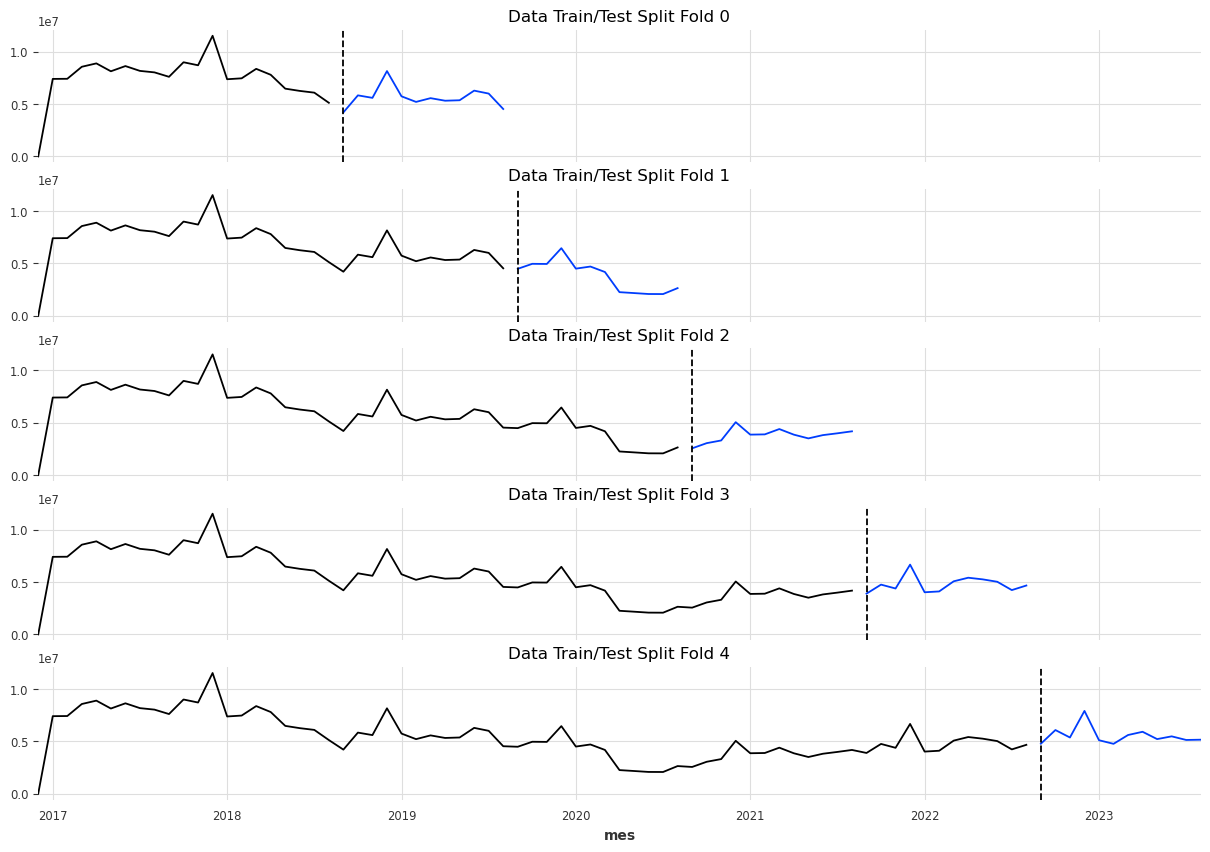

In [366]:
fig, axs = plt.subplots(tss.get_n_splits(), 1, figsize=(15, 10), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    val = df.iloc[val_idx]
    train['v_total'].plot(ax=axs[fold],
                            label='Training Set',
                            title=f'Data Train/Test Split Fold {fold}')
    val['v_total'].plot(ax=axs[fold],label='Val Set')
    axs[fold].axvline(val.index.min(), color='black', ls='--')
    fold += 1
plt.show()

In [367]:
for i, (train_index, test_index) in enumerate(tss.split(df)):
     print(f"Fold {i}:")
     print(f"  Train: index={train_index}")
     print(f"  Test:  index={test_index}")

Fold 0:
  Train: index=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
  Test:  index=[21 22 23 24 25 26 27 28 29 30 31 32]
Fold 1:
  Train: index=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32]
  Test:  index=[33 34 35 36 37 38 39 40 41 42 43 44]
Fold 2:
  Train: index=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44]
  Test:  index=[45 46 47 48 49 50 51 52 53 54 55 56]
Fold 3:
  Train: index=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56]
  Test:  index=[57 58 59 60 61 62 63 64 65 66 67 68]
Fold 4:
  Train: index=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 6

In [368]:
# print('Cantidad de NaNs:')
# for column in df:
#     nans = df[column].isna().sum()
#     print(f'\tColumna {column}: {nans}')

In [369]:
fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
        train = df.iloc[train_idx]
        val = df.iloc[val_idx]

        FEATURES = train[train.columns.difference(['v_total'])].columns
        TARGET = 'v_total'

        X_train = train[FEATURES]
        y_train = train[TARGET]

        X_val = val[FEATURES]
        y_val = val[TARGET]

        reg = xgb.XGBRegressor(booster='gbtree', #utilizar modelado basado en árboles
                        n_estimators=1000, #n_estimators – Número de árboles que llevan a cabo el boosting. También se entiendo como el número de iteraciones de boosting.
                        objective='reg:linear', #Aquí es donde se indica si queremos hacer regresión
                        max_depth=3, #Máxima profundidad de un arbol.
                        learning_rate=0.02,
                        )
        reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        eval_metric=['rmse', 'mae'],
        verbose=100)

        y_pred = reg.predict(X_val)
        preds.append(y_pred)
        score = np.sqrt(mean_squared_error(y_val, y_pred))
        scores.append(score)

[18:21:06] WARNING: D:\bld\xgboost-split_1700182179651\work\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:7620099.04946	validation_0-mae:7332079.57119	validation_1-rmse:5607385.80557	validation_1-mae:5525023.12500
[100]	validation_0-rmse:1395101.49440	validation_0-mae:1157039.50863	validation_1-rmse:2800819.04778	validation_1-mae:1704003.08333


[200]	validation_0-rmse:400920.56238	validation_0-mae:242905.76637	validation_1-rmse:2663877.55134	validation_1-mae:1460808.29167
[300]	validation_0-rmse:139253.19488	validation_0-mae:72773.72359	validation_1-rmse:2684330.14100	validation_1-mae:1542137.50000
[400]	validation_0-rmse:53788.58587	validation_0-mae:31261.35565	validation_1-rmse:2713770.33816	validation_1-mae:1574584.87500
[500]	validation_0-rmse:22152.38543	validation_0-mae:14648.44587	validation_1-rmse:2726711.59353	validation_1-mae:1585869.87500
[600]	validation_0-rmse:10098.52168	validation_0-mae:7575.34491	validation_1-rmse:2733138.05178	validation_1-mae:1590800.41667
[700]	validation_0-rmse:4527.12243	validation_0-mae:3642.28044	validation_1-rmse:2736411.60621	validation_1-mae:1592757.12500
[800]	validation_0-rmse:1827.50363	validation_0-mae:1486.37516	validation_1-rmse:2737469.02893	validation_1-mae:1593338.87500
[900]	validation_0-rmse:731.55791	validation_0-mae:599.16417	validation_1-rmse:2737916.09080	validation_1-

In [370]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 1449350.4758
Fold scores:[2738131.6314811152, 1823619.5974592105, 1165367.7342356993, 837394.3809557793, 682239.0349883144]


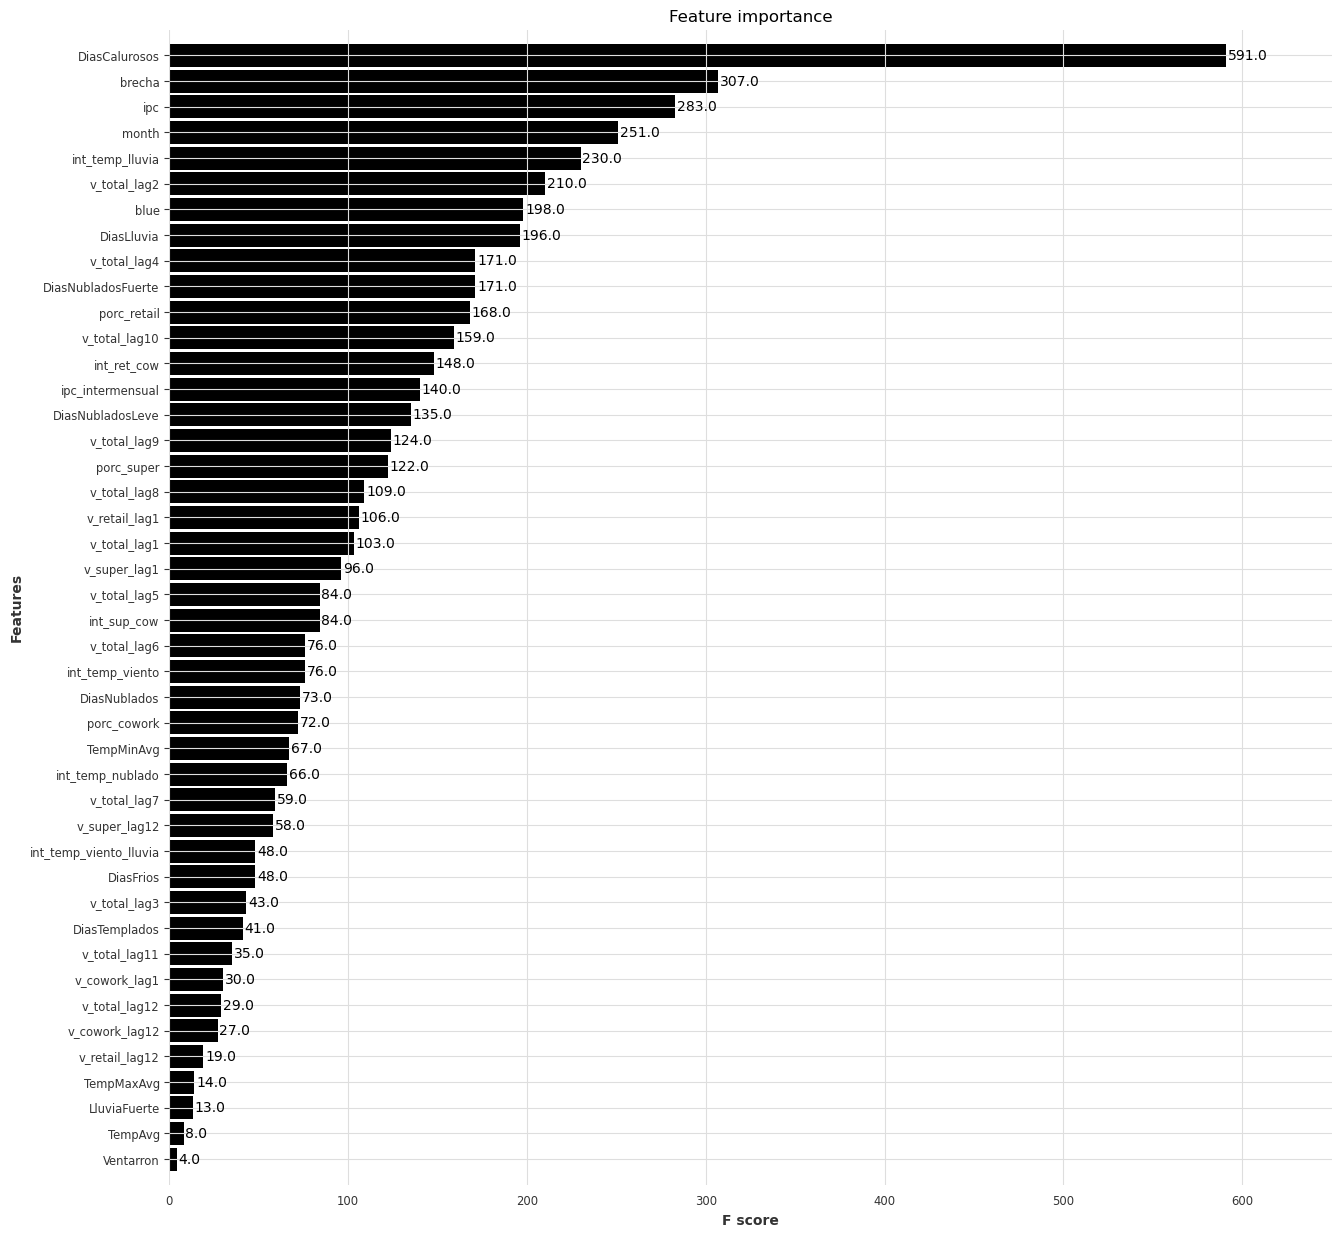

In [371]:
fig, ax = plt.subplots(1,1,figsize=(15,15))
ax = plot_importance(reg, height=0.9, ax=ax)

In [372]:
y_pred = reg.predict(X_val)

In [373]:
val['prediction'] = reg.predict(X_val)

In [374]:
val['prediction']

mes
2022-09-01    4702755.5
2022-10-01    5157286.0
2022-11-01    5251134.5
2022-12-01    5969641.0
2023-01-01    5448556.0
2023-02-01    4831145.5
2023-03-01    5172134.5
2023-04-01    5235590.5
2023-05-01    5207107.0
2023-06-01    5140385.5
2023-07-01    4809805.5
2023-08-01    5044995.0
Name: prediction, dtype: float32

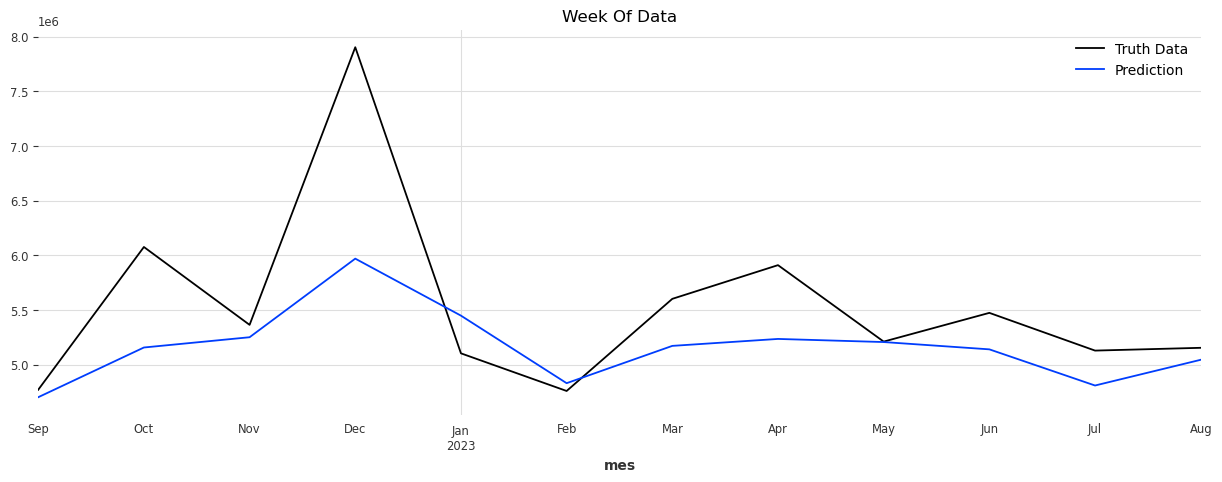

In [375]:
ax = val['v_total'].plot(figsize=(15, 5), title='Week Of Data')
val['prediction'].plot()
plt.legend(['Truth Data','Prediction'])
plt.show()

In [376]:
print(f"Mean Squared Error (MSE): {mean_squared_error(y_val, y_pred):.2e}")
print(f"Mean Absolute Error (MAE):{mean_absolute_error(y_val, y_pred):.2e}")
print(f'Root Mean Squared Error (RMSE): {np.sqrt(mean_squared_error(y_val, y_pred)):.2e}')

Mean Squared Error (MSE): 4.65e+11
Mean Absolute Error (MAE):4.43e+05
Root Mean Squared Error (RMSE): 6.82e+05
